In [1]:
import numpy as np
import pandas as pd
import pickle

from collections import Counter
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from unidecode import unidecode

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn import preprocessing
import re
from bs4 import BeautifulSoup
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report
from sklearn import metrics
from simpletransformers.model import TransformerModel
import tensorflow_hub as hub

from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import SpatialDropout1D, Input, Embedding, Conv1D, BatchNormalization, Activation, Add, MaxPooling1D, MaxPool1D, Dense, Flatten, Bidirectional, LSTM, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D, GRU
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, TensorBoard

import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx

import shap
import lime

from lime.lime_text import LimeTextExplainer

%matplotlib inline
# from nltk.stem.snowball import SnowballStemmer

# stemmer = SnowballStemmer("portuguese")

Using TensorFlow backend.


In [4]:
df = pd.read_json('../../data/News_Category_Dataset_v2.json', lines=True)

In [5]:
df.head()

category                                           headline  \
0          CRIME  There Were 2 Mass Shootings In Texas Last Week...   
1  ENTERTAINMENT  Will Smith Joins Diplo And Nicky Jam For The 2...   
2  ENTERTAINMENT    Hugh Grant Marries For The First Time At Age 57   
3  ENTERTAINMENT  Jim Carrey Blasts 'Castrato' Adam Schiff And D...   
4  ENTERTAINMENT  Julianna Margulies Uses Donald Trump Poop Bags...   

           authors                                               link  \
0  Melissa Jeltsen  https://www.huffingtonpost.com/entry/texas-ama...   
1    Andy McDonald  https://www.huffingtonpost.com/entry/will-smit...   
2       Ron Dicker  https://www.huffingtonpost.com/entry/hugh-gran...   
3       Ron Dicker  https://www.huffingtonpost.com/entry/jim-carre...   
4       Ron Dicker  https://www.huffingtonpost.com/entry/julianna-...   

                                   short_description       date  
0  She left her husband. He killed their children... 2018-05-26  
1                           Of course it has a song. 2018-05-26  
2  The actor and his longtime girlfriend Anna Ebe... 2018-05-26  
3  The actor gives Dems an ass-kicking for not fi... 2018-05-26  
4  The "Dietland" actress said using the bags is ... 2018-05-26

# Plano de ação

Irei dividir a implementação do modelo de IA em basicamente 3 frentes: Estratégia, Representação númerica do texto e Modelo. Irei testar as seguintes abordagens:

- Estratégia:
    - Unir Título e Descrição Curta em um único texto
    - Treinar modelos separados para cada uma.
        - Se a classificação foi igual, OK. Se não, prevalece a predição que apresentou maior confiança.

- Modelos + Embeddings:
    - Random Forest Classifier / XGBoost Classifier / MultinomialNB / ComplementNB
        - TF-IDF
        - Doc2Vec
        - BERT Embedding
    - CNN + LSTM / Bidirectional GRU + Conv 
        - Universal Sentence Encoder

# Pré-processamento

In [6]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(nltk.corpus.stopwords.words('english')+['new', 'news', 'one', 'says', '-', 'people', 'like'])

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = str(text)
    
    text = unidecode(text)
    text = BeautifulSoup(text, "html.parser").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

In [7]:
print('Limpando título...')
df['headline'] = df['headline'].apply(clean_text)
print('Limpando descrição...')
df['short_description'] = df['short_description'].apply(clean_text)
print( 'Done.')

Limpando título...
Limpando descrição...
Done.


In [8]:
df.head()

category                                           headline  \
0          CRIME              2 mass shootings texas last week 1 tv   
1  ENTERTAINMENT  smith joins diplo nicky jam 2018 world cups of...   
2  ENTERTAINMENT               hugh grant marries first time age 57   
3  ENTERTAINMENT  jim carrey blasts castrato adam schiff democra...   
4  ENTERTAINMENT  julianna margulies uses donald trump poop bags...   

           authors                                               link  \
0  Melissa Jeltsen  https://www.huffingtonpost.com/entry/texas-ama...   
1    Andy McDonald  https://www.huffingtonpost.com/entry/will-smit...   
2       Ron Dicker  https://www.huffingtonpost.com/entry/hugh-gran...   
3       Ron Dicker  https://www.huffingtonpost.com/entry/jim-carre...   
4       Ron Dicker  https://www.huffingtonpost.com/entry/julianna-...   

                                   short_description       date  
0   left husband killed children another day america 2018-05-26  
1                                        course song 2018-05-26  
2  actor longtime girlfriend anna eberstein tied ... 2018-05-26  
3  actor gives dems asskicking fighting hard enou... 2018-05-26  
4  dietland actress said using bags really cathar... 2018-05-26

# Estratégia

Como ainda não iremos trabalhar em cima do modelo em si nem da representação numérica, utilizarei um modelo mais básico, apenas para determinar qual é a melhor abordagem entre as 2 que foram definidas, e também utilizarei o TF-IDF como padrão para o embedding.

## Unindo os textos

In [9]:
unified_texts = []

for i, row in tqdm_notebook(df.iterrows()):
    
    text_aux = row['headline']+' '+row['short_description']
    
    unified_texts.append(text_aux)
    
df['unified_texts'] = unified_texts

In [15]:
df.head()

category                                           headline  \
0          CRIME              2 mass shootings texas last week 1 tv   
1  ENTERTAINMENT  smith joins diplo nicky jam 2018 world cups of...   
2  ENTERTAINMENT               hugh grant marries first time age 57   
3  ENTERTAINMENT  jim carrey blasts castrato adam schiff democra...   
4  ENTERTAINMENT  julianna margulies uses donald trump poop bags...   

           authors                                               link  \
0  Melissa Jeltsen  https://www.huffingtonpost.com/entry/texas-ama...   
1    Andy McDonald  https://www.huffingtonpost.com/entry/will-smit...   
2       Ron Dicker  https://www.huffingtonpost.com/entry/hugh-gran...   
3       Ron Dicker  https://www.huffingtonpost.com/entry/jim-carre...   
4       Ron Dicker  https://www.huffingtonpost.com/entry/julianna-...   

                                   short_description       date  \
0   left husband killed children another day america 2018-05-26   
1                                        course song 2018-05-26   
2  actor longtime girlfriend anna eberstein tied ... 2018-05-26   
3  actor gives dems asskicking fighting hard enou... 2018-05-26   
4  dietland actress said using bags really cathar... 2018-05-26   

                                       unified_texts  
0  2 mass shootings texas last week 1 tv left hus...  
1  smith joins diplo nicky jam 2018 world cups of...  
2  hugh grant marries first time age 57 actor lon...  
3  jim carrey blasts castrato adam schiff democra...  
4  julianna margulies uses donald trump poop bags...

In [42]:
#Pipeline com tfidf e LogReg
clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression())
])

In [44]:
x_train, x_test, y_train, y_test = train_test_split(df['unified_texts'].values, df['category'].values, random_state=42, test_size = 0.3)

In [47]:
clf.fit(x_train, y_train)

/home/bruno/anaconda3/envs/sigalei/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
  

In [49]:
preds = clf.predict(x_test)

In [50]:
print(classification_report(y_test, preds))

                precision    recall  f1-score   support

          ARTS       0.38      0.15      0.21       433
ARTS & CULTURE       0.36      0.12      0.18       413
  BLACK VOICES       0.54      0.36      0.43      1345
      BUSINESS       0.51      0.46      0.48      1746
       COLLEGE       0.45      0.28      0.34       349
        COMEDY       0.60      0.40      0.48      1575
         CRIME       0.55      0.55      0.55       948
CULTURE & ARTS       0.67      0.22      0.34       316
       DIVORCE       0.82      0.67      0.74      1046
     EDUCATION       0.50      0.21      0.29       293
 ENTERTAINMENT       0.51      0.79      0.62      4744
   ENVIRONMENT       0.61      0.14      0.22       414
         FIFTY       0.52      0.11      0.19       402
  FOOD & DRINK       0.63      0.76      0.69      1901
     GOOD NEWS       0.42      0.13      0.20       409
         GREEN       0.44      0.35      0.39       779
HEALTHY LIVING       0.40      0.20      0.27  

In [51]:
print(cross_val_score(clf, df['unified_texts'].values, df['category'].values, cv=5))

/home/bruno/anaconda3/envs/sigalei/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/bruno/anaconda3/envs/sigalei/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stabl

[0.55622215 0.57539021 0.58957955 0.57149614 0.55782923]


A Regressão Logística atingiu um F1-Score de 60%

## Trabalhando com os textos separados

In [10]:
df_train, df_test = train_test_split(df, random_state=42, test_size = 0.3)

In [38]:
def pipeline_prediction(headline, description):
    
    pred_headline = clf_headline.predict([headline])
    pred_proba_headline = clf_headline.predict_proba([headline])
    
    pred_description = clf_description.predict([description])
    pred_proba_description = clf_description.predict_proba([description])
    
    #Se as predições dorem iguais, OK
    if pred_headline == pred_description:
        
        return pred_headline
    
    #Se não, seleciona aquela que teve uma maior taxa de confiança
    else:
        
        if pred_proba_headline.max() > pred_proba_description.max():
            
            return pred_headline
        
        else:
            
            return pred_description

### Título

In [20]:
clf_headline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression())
])

In [22]:
clf_headline.fit(df_train['headline'], df_train['category'])

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
  

In [23]:
preds = clf_headline.predict(df_test['headline'])

In [24]:
print(classification_report(df_test['category'], preds))

                precision    recall  f1-score   support

          ARTS       0.34      0.15      0.21       433
ARTS & CULTURE       0.34      0.05      0.09       413
  BLACK VOICES       0.55      0.32      0.41      1345
      BUSINESS       0.48      0.41      0.44      1746
       COLLEGE       0.50      0.19      0.27       349
        COMEDY       0.62      0.39      0.48      1575
         CRIME       0.51      0.48      0.50       948
CULTURE & ARTS       0.82      0.20      0.32       316
       DIVORCE       0.81      0.61      0.70      1046
     EDUCATION       0.43      0.29      0.35       293
 ENTERTAINMENT       0.51      0.76      0.61      4744
   ENVIRONMENT       0.63      0.14      0.24       414
         FIFTY       0.44      0.12      0.19       402
  FOOD & DRINK       0.62      0.69      0.65      1901
     GOOD NEWS       0.44      0.13      0.20       409
         GREEN       0.45      0.28      0.34       779
HEALTHY LIVING       0.31      0.14      0.20  

### Descrição

In [25]:
clf_description = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression())
])

In [26]:
clf_description.fit(df_train['short_description'], df_train['category'])

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
  

In [27]:
preds = clf_description.predict(df_test['short_description'])

In [28]:
print(classification_report(df_test['category'], preds))

                precision    recall  f1-score   support

          ARTS       0.35      0.04      0.07       433
ARTS & CULTURE       0.22      0.01      0.03       413
  BLACK VOICES       0.47      0.15      0.23      1345
      BUSINESS       0.41      0.26      0.32      1746
       COLLEGE       0.29      0.07      0.11       349
        COMEDY       0.41      0.11      0.17      1575
         CRIME       0.44      0.24      0.31       948
CULTURE & ARTS       0.47      0.06      0.10       316
       DIVORCE       0.75      0.48      0.59      1046
     EDUCATION       0.34      0.16      0.22       293
 ENTERTAINMENT       0.32      0.50      0.39      4744
   ENVIRONMENT       0.69      0.09      0.15       414
         FIFTY       0.25      0.00      0.01       402
  FOOD & DRINK       0.53      0.56      0.55      1901
     GOOD NEWS       0.00      0.00      0.00       409
         GREEN       0.36      0.09      0.15       779
HEALTHY LIVING       0.24      0.05      0.08  

In [41]:
preds = []
for i, row in tqdm_notebook(df_test.iterrows()):
    
    pred = pipeline_prediction(row['headline'], row['short_description'])
    
    preds.append(pred)

In [42]:
print(classification_report(df_test['category'], preds))

                precision    recall  f1-score   support

          ARTS       0.39      0.13      0.19       433
ARTS & CULTURE       0.41      0.04      0.08       413
  BLACK VOICES       0.58      0.31      0.40      1345
      BUSINESS       0.52      0.42      0.47      1746
       COLLEGE       0.49      0.17      0.25       349
        COMEDY       0.68      0.37      0.48      1575
         CRIME       0.54      0.49      0.51       948
CULTURE & ARTS       0.76      0.20      0.31       316
       DIVORCE       0.81      0.69      0.75      1046
     EDUCATION       0.40      0.28      0.33       293
 ENTERTAINMENT       0.53      0.77      0.63      4744
   ENVIRONMENT       0.68      0.14      0.23       414
         FIFTY       0.49      0.07      0.13       402
  FOOD & DRINK       0.63      0.74      0.68      1901
     GOOD NEWS       0.52      0.11      0.18       409
         GREEN       0.45      0.21      0.29       779
HEALTHY LIVING       0.39      0.11      0.17  

## Conclusão da estratégia

- Unindo os textos

    - Com essa abordagem, utilizando o Tf-Idf como embedding e uma Regressão Logística como modelo, atingimos um F1-Score de 60%.
    
- Textos separados

    - Já trabalhando com o textos separados, o F1-Score foi de 58%, 2% a menos do que no caso anterior.
    
Logo, iremos prosseguir trabalhando com os textos concatenados!

# Modelos + Embedding

In [9]:
def trainning_evaluate_model(model, df):
    
    df_train, df_test = train_test_split(df, random_state=42, test_size = 0.3)
    
    model.fit(df_train['unified_texts'], df_train['category'])
    
    preds = model.predict(df_test['unified_texts'])
    
    print(classification_report(df_test['category'], preds))
    
    

## Tf-Idf + Random Forest Classifier

In [47]:
clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier())
])

trainning_evaluate_model(clf, df)

                precision    recall  f1-score   support

          ARTS       0.33      0.24      0.28       433
ARTS & CULTURE       0.38      0.03      0.06       413
  BLACK VOICES       0.50      0.22      0.30      1345
      BUSINESS       0.44      0.36      0.40      1746
       COLLEGE       0.44      0.27      0.33       349
        COMEDY       0.44      0.34      0.38      1575
         CRIME       0.43      0.47      0.45       948
CULTURE & ARTS       0.95      0.19      0.31       316
       DIVORCE       0.86      0.64      0.73      1046
     EDUCATION       0.46      0.23      0.31       293
 ENTERTAINMENT       0.48      0.71      0.57      4744
   ENVIRONMENT       1.00      0.10      0.18       414
         FIFTY       0.27      0.02      0.04       402
  FOOD & DRINK       0.55      0.71      0.62      1901
     GOOD NEWS       0.37      0.05      0.09       409
         GREEN       0.42      0.23      0.30       779
HEALTHY LIVING       0.30      0.27      0.28  

## Tf-Idf + XGBoost Classifier

In [10]:
clf_xgboost = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', XGBClassifier(n_estimators=500))
])

trainning_evaluate_model(clf_xgboost, df)

                precision    recall  f1-score   support

          ARTS       0.39      0.28      0.33       433
ARTS & CULTURE       0.39      0.27      0.32       413
  BLACK VOICES       0.52      0.37      0.43      1345
      BUSINESS       0.49      0.45      0.47      1746
       COLLEGE       0.46      0.38      0.42       349
        COMEDY       0.60      0.43      0.50      1575
         CRIME       0.53      0.53      0.53       948
CULTURE & ARTS       0.54      0.30      0.38       316
       DIVORCE       0.81      0.73      0.77      1046
     EDUCATION       0.47      0.38      0.42       293
 ENTERTAINMENT       0.54      0.72      0.62      4744
   ENVIRONMENT       0.56      0.23      0.33       414
         FIFTY       0.42      0.20      0.27       402
  FOOD & DRINK       0.62      0.69      0.65      1901
     GOOD NEWS       0.38      0.21      0.27       409
         GREEN       0.42      0.36      0.39       779
HEALTHY LIVING       0.42      0.32      0.36  

## Tf-Idf + Multinomial Naive Bayes

In [52]:
clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

trainning_evaluate_model(clf, df)

                precision    recall  f1-score   support

          ARTS       0.00      0.00      0.00       433
ARTS & CULTURE       0.00      0.00      0.00       413
  BLACK VOICES       0.00      0.00      0.00      1345
      BUSINESS       0.85      0.02      0.03      1746
       COLLEGE       0.00      0.00      0.00       349
        COMEDY       1.00      0.00      0.01      1575
         CRIME       0.75      0.01      0.02       948
CULTURE & ARTS       0.00      0.00      0.00       316
       DIVORCE       0.96      0.04      0.08      1046
     EDUCATION       0.00      0.00      0.00       293
 ENTERTAINMENT       0.48      0.74      0.58      4744
   ENVIRONMENT       0.00      0.00      0.00       414
         FIFTY       0.00      0.00      0.00       402
  FOOD & DRINK       0.72      0.41      0.53      1901
     GOOD NEWS       0.00      0.00      0.00       409
         GREEN       1.00      0.00      0.00       779
HEALTHY LIVING       1.00      0.00      0.00  

## Tf-Idf + Complement Naive Bayes

In [53]:
clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', ComplementNB())
])

trainning_evaluate_model(clf, df)

                precision    recall  f1-score   support

          ARTS       0.36      0.12      0.18       433
ARTS & CULTURE       0.41      0.08      0.13       413
  BLACK VOICES       0.60      0.25      0.35      1345
      BUSINESS       0.52      0.35      0.42      1746
       COLLEGE       0.44      0.20      0.28       349
        COMEDY       0.60      0.25      0.35      1575
         CRIME       0.48      0.49      0.49       948
CULTURE & ARTS       0.55      0.17      0.26       316
       DIVORCE       0.77      0.73      0.75      1046
     EDUCATION       0.53      0.10      0.17       293
 ENTERTAINMENT       0.58      0.76      0.66      4744
   ENVIRONMENT       0.60      0.13      0.21       414
         FIFTY       0.56      0.08      0.14       402
  FOOD & DRINK       0.54      0.82      0.65      1901
     GOOD NEWS       0.31      0.09      0.13       409
         GREEN       0.42      0.25      0.31       779
HEALTHY LIVING       0.49      0.07      0.12  

Utilizando Tf-Idf, sem nenhuma hiper-parametrização, o XGBoost Classifier foi o que obteve uma melhor performance com 60% de F1-Score. Vamos testar agora realizando o embedding com o Doc2Vec do gensim.

# Doc2Vec

## Trainning Doc2Vec Model

In [58]:
df['unified_texts'].values

array(['2 mass shootings texas last week 1 tv left husband killed children another day america',
       'smith joins diplo nicky jam 2018 world cups official song course song',
       'hugh grant marries first time age 57 actor longtime girlfriend anna eberstein tied knot civil ceremony',
       ...,
       'giants patriots jets colts among improbable super bowl upsets time videos leading super bowl xlvi talked game could end occurred years ago',
       'aldon smith arrested 49ers linebacker busted dui correction earlier version story incorrectly stated location ktvu 2011 league leader sacks',
       'dwight howard rips teammates magic loss hornets fivetime allstar center tore teammates friday night orlando committed 23 turnovers en route losing'],
      dtype=object)

In [59]:
splitted_texts = []

for text in df['unified_texts'].values:
    
    splitted_texts.append(text.split())

In [60]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(splitted_texts)]
model = Doc2Vec(documents, vector_size=200, window=2, min_count=1, workers=6)

In [62]:
#Saving Model
# name = get_tmpfile("my_doc2vec_model")

# model.save(name)

#Load Model
# model = Doc2Vec.load(name)

In [64]:
X = []
for text in tqdm_notebook(df['unified_texts'].values):
    vector = model.infer_vector(text.split())
    X.append(vector)

In [65]:
X[0]

array([-0.01008541,  0.05884872,  0.02031498,  0.0877751 ,  0.01794297,
        0.06118095, -0.00353747, -0.03141512,  0.00494216, -0.01551989,
        0.02624725,  0.0266431 ,  0.02930043,  0.02953379, -0.00724472,
        0.01168052, -0.03240382, -0.00862945,  0.01800433,  0.03863771,
       -0.01473222,  0.01973411, -0.06987792, -0.01576914,  0.00344562,
        0.02606658, -0.04808196, -0.02962354, -0.03504297, -0.02599452,
       -0.01060749,  0.03359263,  0.01857985, -0.00731564, -0.00395095,
        0.02896644, -0.02959264,  0.01307354,  0.0181507 , -0.0394212 ,
        0.0100285 , -0.05060272, -0.0036352 , -0.01761939, -0.020494  ,
        0.06531225,  0.0776489 , -0.05666714,  0.04407891,  0.02059903,
       -0.01595151, -0.01873897, -0.02119827,  0.00663208,  0.00722386,
        0.00752277, -0.00370711, -0.00418458, -0.01532599, -0.01662857,
        0.02316276, -0.03198561,  0.04184886,  0.00920135,  0.04287969,
       -0.00966456, -0.00779942, -0.02444633,  0.01362711, -0.04

In [66]:
xgb_classifier = XGBClassifier(n_estimator=500)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), df['category'], test_size = 0.3, random_state=42)

In [71]:
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimator=500, n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [72]:
preds = xgb_classifier.predict(X_test)

In [73]:
print(classification_report(y_test, preds))

                precision    recall  f1-score   support

          ARTS       0.18      0.06      0.09       433
ARTS & CULTURE       0.23      0.03      0.06       413
  BLACK VOICES       0.35      0.16      0.22      1345
      BUSINESS       0.28      0.22      0.24      1746
       COLLEGE       0.41      0.10      0.16       349
        COMEDY       0.24      0.10      0.14      1575
         CRIME       0.38      0.39      0.38       948
CULTURE & ARTS       0.28      0.04      0.07       316
       DIVORCE       0.52      0.39      0.45      1046
     EDUCATION       0.33      0.09      0.14       293
 ENTERTAINMENT       0.35      0.59      0.44      4744
   ENVIRONMENT       0.23      0.03      0.06       414
         FIFTY       0.08      0.01      0.01       402
  FOOD & DRINK       0.45      0.53      0.48      1901
     GOOD NEWS       0.14      0.04      0.06       409
         GREEN       0.23      0.09      0.13       779
HEALTHY LIVING       0.25      0.20      0.22  

Realizar o embedding utilizando Doc2Vec não deu muito certo... Vamos tentar utilizar um embedding mais atual, utilizando o [BERT](https://github.com/google-research/bert), na biblioteca [Simple Transformers](https://github.com/ThilinaRajapakse/simpletransformers)

# BERT Embedding

In [5]:
encoder = preprocessing.LabelEncoder()

In [8]:
# Os labels precisam ser inteiros, não funciona sendo str
df['category'] = encoder.fit_transform(df['category'])

In [7]:
# Create a TransformerModel

#!!! ISSO DEMORA!!!
model = TransformerModel('bert', 'bert-base-multilingual-cased', num_labels=41, args = {
    "output_dir": "outputs/",
    "cache_dir": "cache_dir/",

    "fp16": False,
    "fp16_opt_level": "O1",
    "max_seq_length": 512,
    "train_batch_size": 8,
    "gradient_accumulation_steps": 1,
    "eval_batch_size": 8,
    "num_train_epochs": 1,
    "weight_decay": 0,
    "learning_rate": 4e-5,
    "adam_epsilon": 1e-8,
    "warmup_ratio": 0.06,
    "warmup_steps": 0,
    "max_grad_norm": 1.0,

    "logging_steps": 50,
    "save_steps": 2000,

    "overwrite_output_dir": True,
    "reprocess_input_data": True
})

In [11]:
df_train, df_test = train_test_split(df[['unified_texts', 'category']], random_state=42, test_size = 0.3)

In [12]:
model.train_model(df_train)

RuntimeError: CUDA out of memory. Tried to allocate 96.00 MiB (GPU 0; 5.94 GiB total capacity; 4.92 GiB already allocated; 20.62 MiB free; 4.96 GiB reserved in total by PyTorch)

In [ ]:
predictions, raw_outputs = model.predict(df_test['unified_text'])

### Obs: Infelizmente por ser um dataset muito grande, minha máquina não aguentou alocar memória para tantos dados utilizando o BERT :(

# Neural Networks + Universal Sentence Encoder

Vamos testar agora as famosas Redes Neurais. Irei treinar uma rede que irá possuir camadas convolucionais e recorrentes, utilizando como embedding um modelo prétreinado do Google chamado [Universal Sentence Encoder](https://arxiv.org/abs/1803.11175)

In [2]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder-large/5'.
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder-large/5: 80.04MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder-large/5: 190.04MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder-large/5: 300.04MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder-large/5: 400.04MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder-large/5: 500.04MB
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder-large/5, Total size: 577.10MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder-large/5'.


In [34]:
#Convertendo todas os textos para a representação. DEMORA!
df_final = pd.DataFrame()
for text in tqdm_notebook(df['unified_texts'].values):
    vector = embed([text])
    df_aux = pd.DataFrame([vector[0].numpy()])
    
    df_final = pd.concat([df_final, df_aux])

In [35]:
df_final['label'] = df['category'].values

In [48]:
df_final.columns = df_final.columns.astype(str)

In [50]:
df_final.to_feather('dataset_universal_sentence_encoder.ftr')

In [2]:
df_final = pd.read_feather('dataset_universal_sentence_encoder.ftr')

In [3]:
df_final.head()

0         1         2         3         4         5         6  \
0  0.006363  0.049869 -0.000878 -0.000673  0.096477  0.087338 -0.031699   
1  0.048103 -0.009488 -0.021072  0.037653 -0.016569  0.022834 -0.031096   
2 -0.026913  0.080804 -0.007056  0.034460  0.116786 -0.033103  0.039886   
3  0.005778 -0.050576  0.011790 -0.005444  0.054885  0.012013  0.025647   
4 -0.020502  0.000580 -0.005970 -0.031167  0.028395  0.090319  0.010090   

          7         8         9  ...       503       504       505       506  \
0 -0.072114 -0.046030 -0.021631  ... -0.001837  0.125564  0.045575 -0.007552   
1  0.014093  0.009831  0.004199  ...  0.001038  0.015422 -0.011731  0.029707   
2  0.058613  0.006389  0.028698  ... -0.034202  0.008968  0.045408 -0.026497   
3  0.014921 -0.008079  0.015543  ...  0.018556  0.095446  0.001719  0.035923   
4  0.009515 -0.030132 -0.009199  ... -0.039469  0.030342 -0.017494 -0.001721   

        507       508       509       510       511          label  
0  0.035581  0.007251  0.051346 -0.004795 -0.017232          CRIME  
1 -0.022375 -0.018772 -0.030358  0.076663 -0.017785  ENTERTAINMENT  
2 -0.052790 -0.082210  0.075247  0.008118 -0.068863  ENTERTAINMENT  
3  0.010300 -0.007544  0.030701 -0.041534  0.039088  ENTERTAINMENT  
4 -0.011543 -0.032934  0.020738  0.017703 -0.067583  ENTERTAINMENT  

[5 rows x 513 columns]

In [5]:
one_hot_encoder_labels = pd.get_dummies(df_final['label'])

## CNN + LSTM DeepNet

In [18]:
def build_model(inputShape):
    model = Sequential()

    model.add(Conv1D(32, kernel_size=3, activation='elu', padding='same', input_shape=(inputShape,1)))
    model.add(MaxPooling1D(pool_size=4))
    model.add(Conv1D(32, kernel_size=3, activation='elu', padding='same'))
    model.add(MaxPooling1D(pool_size=4))
    model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))    
    
    model.add(BatchNormalization())
    

    model.add(Bidirectional(LSTM(512, dropout=0.2, recurrent_dropout=0.3)))

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(41, activation='sigmoid'))

    model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True), metrics=['accuracy'])
    
    return model

In [9]:
x_train, x_test, y_train, y_test = train_test_split(np.array(df_final.iloc[:,:-1]), np.array(one_hot_encoder_labels), random_state=42, test_size=0.3)

In [10]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

x_test.shape

(60256, 512, 1)

In [19]:
model = build_model(inputShape=512)

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 512, 32)           128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 128, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 128, 32)           3104      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 32, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 32, 32)            3104      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32)            128       
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1024)             

In [21]:
model.fit(x_train, y_train, batch_size=100, epochs=10,
         validation_data=(x_test, y_test))

Train on 140597 samples, validate on 60256 samples
Epoch 1/10
140597/140597 [==============================] - 484s 3ms/step - loss: 3.3095 - accuracy: 0.1629 - val_loss: 3.3679 - val_accuracy: 0.1622
Epoch 2/10
140597/140597 [==============================] - 485s 3ms/step - loss: 2.7347 - accuracy: 0.2953 - val_loss: 4.0614 - val_accuracy: 0.2197
Epoch 3/10
140597/140597 [==============================] - 484s 3ms/step - loss: 2.3121 - accuracy: 0.4006 - val_loss: 3.1893 - val_accuracy: 0.2785
Epoch 4/10
140597/140597 [==============================] - 486s 3ms/step - loss: 2.1103 - accuracy: 0.4429 - val_loss: 4.2831 - val_accuracy: 0.1209
Epoch 5/10
140597/140597 [==============================] - 543s 4ms/step - loss: 1.9910 - accuracy: 0.4685 - val_loss: 2.3527 - val_accuracy: 0.3662
Epoch 6/10
140597/140597 [==============================] - 508s 4ms/step - loss: 1.9050 - accuracy: 0.4861 - val_loss: 2.6314 - val_accuracy: 0.3285
Epoch 7/10
140597/140597 [=======================

Depois de 10 épocas, a rede neural atingiu uma acurácia de 53%, apesar de que o loss ainda estava caindo em valores consideráveis, o que sugere que poderiamos aumentar as épocas de treinamento para melhorar a acurácia sem necessariamente estar causando um overfit no modelo.

## Bidirectional GRU + Conv

In [30]:
def build_model_GRU(inputShape):
    model = Sequential()
    
    model.add(SpatialDropout1D(0.25))

    model.add(Bidirectional(GRU(128, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)))
    model.add(Conv1D(64, kernel_size=3))
    model.add(GlobalAveragePooling1D())
    model.add(GlobalMaxPooling1D())    

    model.add(Dense(41, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])
    
    return model

In [31]:
model_gru = build_model_GRU(512)

In [32]:
model.fit(x_train, y_train, batch_size=128, epochs=20,
         validation_data=(x_test, y_test))

Train on 140597 samples, validate on 60256 samples
Epoch 1/20
140597/140597 [==============================] - 447s 3ms/step - loss: 1.6468 - accuracy: 0.5422 - val_loss: 1.9983 - val_accuracy: 0.4668
Epoch 2/20
140597/140597 [==============================] - 496s 4ms/step - loss: 1.6188 - accuracy: 0.5469 - val_loss: 1.7430 - val_accuracy: 0.5201
Epoch 3/20
140597/140597 [==============================] - 587s 4ms/step - loss: 1.5978 - accuracy: 0.5524 - val_loss: 1.6553 - val_accuracy: 0.5415
Epoch 4/20
140597/140597 [==============================] - 482s 3ms/step - loss: 1.5731 - accuracy: 0.5571 - val_loss: 1.9548 - val_accuracy: 0.4569
Epoch 5/20
140597/140597 [==============================] - 515s 4ms/step - loss: 1.5526 - accuracy: 0.5623 - val_loss: 1.6322 - val_accuracy: 0.5474
Epoch 6/20
140597/140597 [==============================] - 664s 5ms/step - loss: 1.5367 - accuracy: 0.5657 - val_loss: 1.7022 - val_accuracy: 0.5295
Epoch 7/20
140597/140597 [=======================

In [37]:
preds = model.predict(x_test)

In [38]:
y_test_true = []
for y in y_test:
    value = np.argmax(y)
    y_test_true.append(value)

In [40]:
y_pred_true = []
for y in preds:
    value = np.argmax(y)
    y_pred_true.append(value)

In [41]:
print(classification_report(y_test_true, y_pred_true))

              precision    recall  f1-score   support

           0       0.23      0.18      0.20       433
           1       0.26      0.14      0.18       413
           2       0.49      0.36      0.41      1345
           3       0.48      0.34      0.40      1746
           4       0.47      0.24      0.32       349
           5       0.61      0.29      0.39      1575
           6       0.58      0.48      0.52       948
           7       0.32      0.25      0.28       316
           8       0.78      0.59      0.67      1046
           9       0.41      0.32      0.36       293
          10       0.57      0.76      0.65      4744
          11       0.32      0.25      0.28       414
          12       0.70      0.06      0.11       402
          13       0.57      0.77      0.66      1901
          14       0.31      0.21      0.25       409
          15       0.34      0.28      0.31       779
          16       0.50      0.10      0.17      1972
          17       0.53    

O F1-Score da rede atingiu 57%. O que não é ruim, mas ainda não bate o XGBoost com o Tf-Idf. Vi que nos Kernels do Kaggle utilizaram o gloVe para fazer o embedding dos textos, entretanto optei por usar o Universal Sentence Encoder que tinha lido no [paperswithcode.com](https://paperswithcode.com/paper/universal-sentence-encoder) que era uma técnica estado da arte para alguns casos. Mas valeu a pena entender como funciona a implementação!

# Resultados

Várias técnicas foram utilizadas, tanto de embedding, quanto de modelos, entretanto a grande quantidade de classes e o desbalanceamento das mesmas dificulta o aprendizado da IA. Entretanto, vamos aos resultados finais:

Obs.: A métrica para verificar os modelos é o F1-Score Micro, para compensar um pouco o desbalanceamento das classes. Por conta de tempo, realizar um Cross-Validation em todos os modelos/embeddings se tornou um pouco inviável.

- Foi decidido unir os textos em apenas um para realizar a classificação

- TF-IDf + Random Forest Classifier: 54%
- TF-IDF + XGBoost Classifier: 60%
- TF-IDF + Multinomial Naive Bayes: 39%
- TF-IDF + Complement Naive Bayes: 57%
- Doc2Vec + XGBoost Classifier: 42%
- BERT: Estourou memória :(
- Universal Sentence Encoder + CNN/LSTM DeepNet: 53%
- Universal Sentence Encoder + Bidirectional GRU/Conv: 57%

Algumas diferentes técnicas e modelos poderiam ser testados, como por exemplo utilizar o gloVe, como foi utilizado nos Kernels do Kaggle, Node2Vec também é uma opção, além de realizar outros testes no pré-processamento como tentar excluir mais palavras comuns ou tentar buscar palavras chaves por classe como foi apontado para algumas classes na Análise Exploratória, ou realizar stemização e lematização no texto.

### Vamos prosseguir então com o TF+IDF e o XGBoost Classifier para colocar o modelo em "produção".

In [12]:
pickle.dump(clf_xgboost, open('../../data/models/xgboost_v1.pkl', 'wb'))

### Confusion Matrix

In [13]:
df_train, df_test = train_test_split(df, random_state=42, test_size = 0.3)

In [16]:
preds = clf_xgboost.predict(df_test['unified_texts'].values)

In [26]:
df_test['category'].values

array(['CRIME', 'POLITICS', 'STYLE & BEAUTY', ..., 'POLITICS', 'RELIGION',
       'TASTE'], dtype=object)

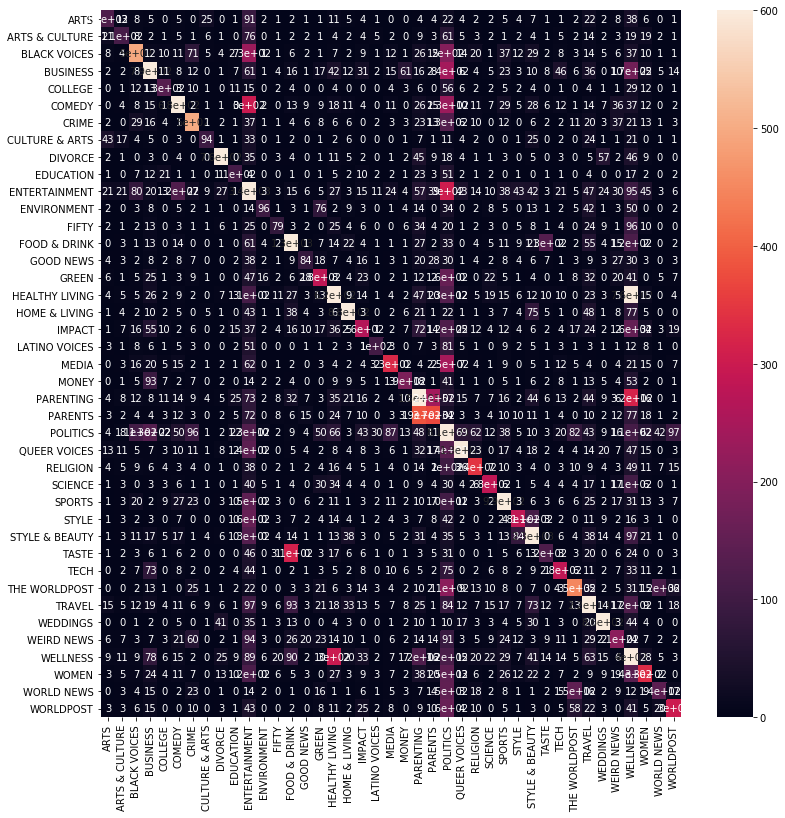

In [34]:
confusion_matrix = metrics.confusion_matrix(df_test['category'].values, preds)

df_cm = pd.DataFrame(confusion_matrix, index = [i for i in np.sort(df_test['category'].unique()).tolist()],
                  columns = [i for i in np.sort(df_test['category'].unique()).tolist()])



plt.figure(figsize = (13,13))
sns.heatmap(df_cm, annot=True, vmax=600)

Pela matriz de confusão podemos ver que a maioria dos erros cometidos pelo modelo ele classifica como "POLITICS", pois a IA possui um viés devido ao desbalanceamento das classes. Teria que realizar um undersampling ou oversampling para tentar equilibrar um pouco o dataset.

# Bônus: Model Explainability with SHAP + Graph

In [62]:

def explainable_words(model, df_test, explainer, num_keywords=8, classes__=None):

    if explainer == 'lime':
        df_test.reset_index(drop=True, inplace=True)

        x_test = df_test['unified_texts']
        y_test = df_test['category']

        classes = model.classes_
        explainer = LimeTextExplainer(class_names=classes)
        indexes = list(x_test.index)

        print(x_test[0])
        
        exp = explainer.explain_instance(x_test[0], model.predict_proba, num_features=1, top_labels=1)
        dict_explainer = {}
        for class_name in exp.class_names:
            dict_explainer[class_name] = {'Correct': {},
                                          'Wrong': {}}

        print(dict_explainer)

        for idx in tqdm_notebook(indexes):

            try:
                exp = explainer.explain_instance(x_test[idx], model.predict_proba, num_features=num_keywords, top_labels=1)

                pred = exp.class_names[exp.available_labels()[0]]

                true_label = y_test[idx]
                
                print(true_label)
                
                print(pred)

                features = exp.as_list(label=exp.available_labels()[0])

                if true_label == pred:

                    for item in features:

                        if item[0] in dict_explainer[true_label]['Correct']:


                            if item[1] > 0:

                                dict_explainer[true_label]['Correct'][item[0]].append(item[1])

                        else:

                            if item[1] > 0:

                                dict_explainer[true_label]['Correct'][item[0]] = [item[1]]

                else:

                    for item in features:

                        if item[0] in dict_explainer[true_label]['Wrong']:

                            if item[1] > 0:

                                dict_explainer[true_label]['Wrong'][item[0]].append(item[1])

                        else:

                            if item[1] > 0:

                                dict_explainer[true_label]['Wrong'][item[0]] = [item[1]]
            except:
                pass

        vect1 = []
        vect2 = []
        vect3 = []
        vect4 = []

        for class_ in dict_explainer.keys():
            for key, value in dict_explainer[class_]['Correct'].items():

                vect1.append(class_)
                vect2.append('Correct')
                vect3.append(key)
                vect4.append(np.array(value).mean())

            for key, value in dict_explainer[class_]['Wrong'].items():

                vect1.append(class_)
                vect2.append('Wrong')
                vect3.append(key)
                vect4.append(np.array(value).mean())

        df_words_explainable = pd.DataFrame({'Classe': vect1, 'Correct/Wrong': vect2, 'Word': vect3, 'Score': vect4})

        return df_words_explainable

    elif explainer == 'shap':

        df_shap = pd.DataFrame()

        classes = classes__

        classes.sort()

        dict_classes = {classe: i for i, classe in enumerate(classes)}
        
        vocabulary = model['vect'].vocabulary_

        inv_vocabulary = {v: k for k, v in vocabulary.items()}

        df_test.reset_index(inplace=True, drop=True)

        explainer = shap.TreeExplainer(model['clf'])

        for i, row in tqdm_notebook(df_test.iterrows()):
            
            df_test_vector = model['vect'].transform([row['unified_texts']])
            
            pred = model['clf'].predict(df_test_vector)

            df_vect = pd.DataFrame(df_test_vector.toarray())

            shap_values = explainer.shap_values(df_vect.iloc[0,:])
            
#             print(shap_values)
            
#             print(shap_values[dict_classes[pred[0]]][0])
            
            correct_wrong = []

            shap_values_for_df = []

            word =[]
            
            if len(dict_classes) == 2:
                for i, shap_value in enumerate(shap_values[0]):
    #                 print(i)
                    if shap_value > 0.01:

                        if pred == row['category']:

                            correct_wrong.append('Correct')

                        else:

                            correct_wrong.append('Wrong')

                        shap_values_for_df.append(shap_value)
                        word.append(inv_vocabulary[i])
            else:
                
                for i, shap_value in enumerate(shap_values[dict_classes[pred[0]]][0]):


                    if shap_value > 0.01:

                        if pred == row['category']:

                            correct_wrong.append('Correct')

                        else:

                            correct_wrong.append('Wrong')

                        shap_values_for_df.append(shap_value)
                        word.append(inv_vocabulary[i])

            df_shap_aux = pd.DataFrame({'Word': word, 'Score': shap_values_for_df, 'Correct/Wrong': correct_wrong})

    #         print(row['Genero'])
            df_shap_aux['Classe'] = row['category']

            df_shap = pd.concat([df_shap_aux, df_shap])

        return df_shap

    else:

        print('ERROR: Explainer must be \"lime\" or \"shap\".')

def graph_lime_analytics(df_words_explainable, threshold = 0.2):
    df_words_explainable_ = df_words_explainable.sort_values(by=['Score'], ascending=False).drop_duplicates(subset=['Classe', 'Word'], keep='first')
    G = nx.Graph()
    color_map = []
    node_size = []
    edge_color_list = []
    for class_ in df_words_explainable_['Classe'].unique():
        color_map.append('red')
        node_size.append(1000)
        G.add_node(class_)

        for i, row in df_words_explainable_[(df_words_explainable_['Classe'] == class_) & (df_words_explainable_['Score'] > threshold)].sort_values(by=['Score'], ascending=False).iterrows():
            if row['Word'] not in G.nodes():
                color_map.append('blue')
                node_size.append(1000*row['Score'])
            G.add_node(row['Word'])
            if row['Correct/Wrong'] == 'Correct':
                G.add_edge(row['Classe'], row['Word'], lenght = row['Score'], color = 'g')
            else:
                G.add_edge(row['Classe'], row['Word'], lenght = row['Score'], color = 'r')

    edges = G.edges()
    colors = [G[u][v]['color'] for u,v in edges]
    plt.figure(figsize=(15,15))
    nx.draw(G, with_labels=True, node_color = color_map, edge_color = colors)

    return G

In [63]:
explainable_df = explainable_words(clf_xgboost, df_test.iloc[:2000,:], 'shap', classes__=df_test['category'].unique())

Essa função utiliza uma biblioteca de explicabilidade para extrair as palavras que foram relevantes para o modelo classificar como determinada classe. Quando foi uma palavra relevante para uma classificação incorreta, a aresta no grafo abaixo é vermelha, quando foi uma inferência correta, é verde. Os nós azuis são as palavras e os nós vermelhos as classes, como há muita informação, fica díficil visualizar. Porém, podemos ver um grande amontoado de palavras no meio do grafo, o que significa que essas palavras foram compartilhadas entre várias classes. As palavras mais externas, que fazem ligação com apenas um nó vermelho, são palavras relevantes para apenas aquela classe a que estão ligadas, o que pode representar uma palavra-chave para ela.

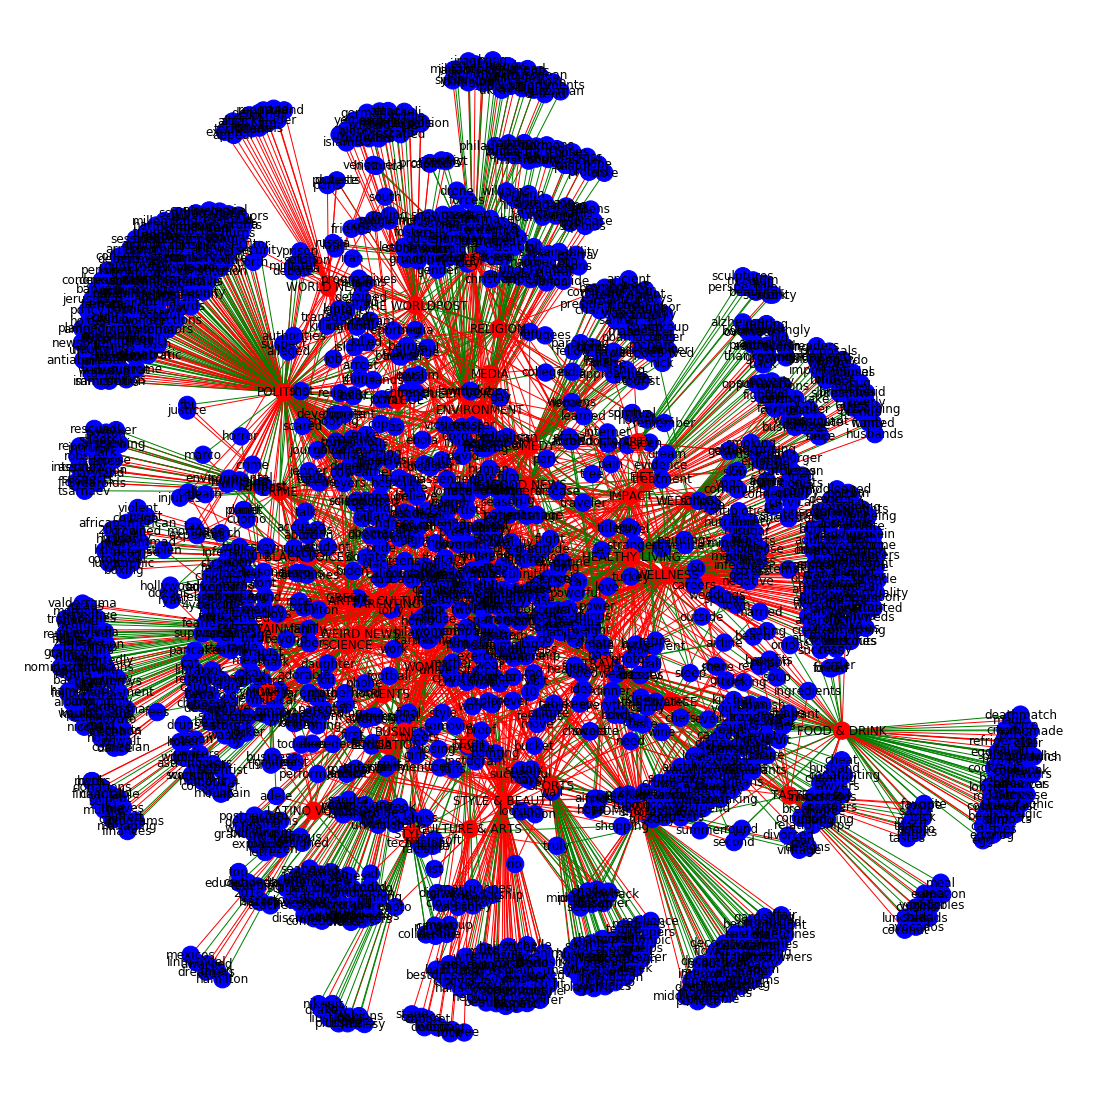

In [67]:
G = graph_lime_analytics(explainable_df, threshold=0.7)

### Explicabilidade local com LIME

Para explicabilidade de textos, não existe uma visualização global como o grafo acima, existem bibliotecas que realizam uma exmplibabilidade local, como é o caso do LIME:

In [2]:
clf_xgboost = pickle.load(open('../../data/models/xgboost_v1.pkl', 'rb'))

In [11]:
np.sort(df_test['category'].unique())

array(['ARTS', 'ARTS & CULTURE', 'BLACK VOICES', 'BUSINESS', 'COLLEGE',
       'COMEDY', 'CRIME', 'CULTURE & ARTS', 'DIVORCE', 'EDUCATION',
       'ENTERTAINMENT', 'ENVIRONMENT', 'FIFTY', 'FOOD & DRINK',
       'GOOD NEWS', 'GREEN', 'HEALTHY LIVING', 'HOME & LIVING', 'IMPACT',
       'LATINO VOICES', 'MEDIA', 'MONEY', 'PARENTING', 'PARENTS',
       'POLITICS', 'QUEER VOICES', 'RELIGION', 'SCIENCE', 'SPORTS',
       'STYLE', 'STYLE & BEAUTY', 'TASTE', 'TECH', 'THE WORLDPOST',
       'TRAVEL', 'WEDDINGS', 'WEIRD NEWS', 'WELLNESS', 'WOMEN',
       'WORLD NEWS', 'WORLDPOST'], dtype=object)

In [12]:
explainer = LimeTextExplainer(class_names=np.sort(df_test['category'].unique()))

In [15]:
df_test.reset_index(drop=True, inplace=True)

In [23]:
exp = explainer.explain_instance(df_test['unified_texts'][1], clf_xgboost.predict_proba, num_features=5, top_labels=1)

In [24]:
df_test['category'][1]

'POLITICS'

In [26]:
exp.show_in_notebook()
plt.show()

In [28]:
exp = explainer.explain_instance(df_test['unified_texts'][2], clf_xgboost.predict_proba, num_features=5, top_labels=2)

A categoria correta era POLITCS, o modelo classificou como MEDIA por conta das palavras 'cnn', 'media' e 'abc'. Podemos notar que o modelo não teve tanta confiança para classificar como MEDIA, justamente porque haviam palavras relavantes para a classe POLITICS também, como era o caso de 'trump' e 'president'.

In [29]:
df_test['category'][2]

'STYLE & BEAUTY'

In [30]:
exp.show_in_notebook()
plt.show()

Esse caso, por outro lado, o modelo classificou corretamente como STYLE & BEAUTY e com uma confiança de 99%, graças as palavras 'kate', 'model', 'fashion', 'vuitton', '2013', o que se for parar para pensar, faz sentido essas palavras para o mundo de STYLE & BEAUTY.

### Fine Tuning

Gostaria de rodar um gridsearch para hiperparamtrizar o modelo, mas acredito que não irá acabar antes do prazo, então só irei deixar a implementação aqui.

In [ ]:
from sklearn.model_selection import GridSearchCV

model = Pipeline(
    [
        ('vectorizer', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', XGBClassifier())
    ]
)

parameters = {'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2), (3, 3)], 
              'tfidf__use_idf': (True, False),
              'clf__min_child_weight': [1, 5, 10],
              'clf__gamma': [0.5, 1, 1.5, 2, 5],
              'clf__subsample': [0.6, 0.8, 1.0],
              'clf__colsample_bytree': [0.6, 0.8, 1.0],
              'clf__max_depth': [3, 4, 5],
              'clf__n_estimators': [300, 500, 700, 1000]
             }

gs_clf = GridSearchCV(model, parameters, scoring = "f1", n_jobs = 8, verbose = 8)
gs_clf = gs_clf.fit(df_train['unified_texts'], df_train['category'])

print(gs_clf.best_score_)
print(gs_clf.best_params_)